# Understanding LangChain v0.2 for Summarisation

LangChain is an open-source framework for developing applications using large language models (LLMs). LLMs are huge deep-learning models that have been pre-trained on vast quantities of data and can respond to user inquiries, such as answering questions or making graphics based on text prompts. LangChain provides tools and abstractions to help models create more customised, accurate, and relevant information.

[Read my previous blog on LangChain for Summarisation](https://medium.com/pythoneers/summarisation-with-langchain-dfc0257042ca)

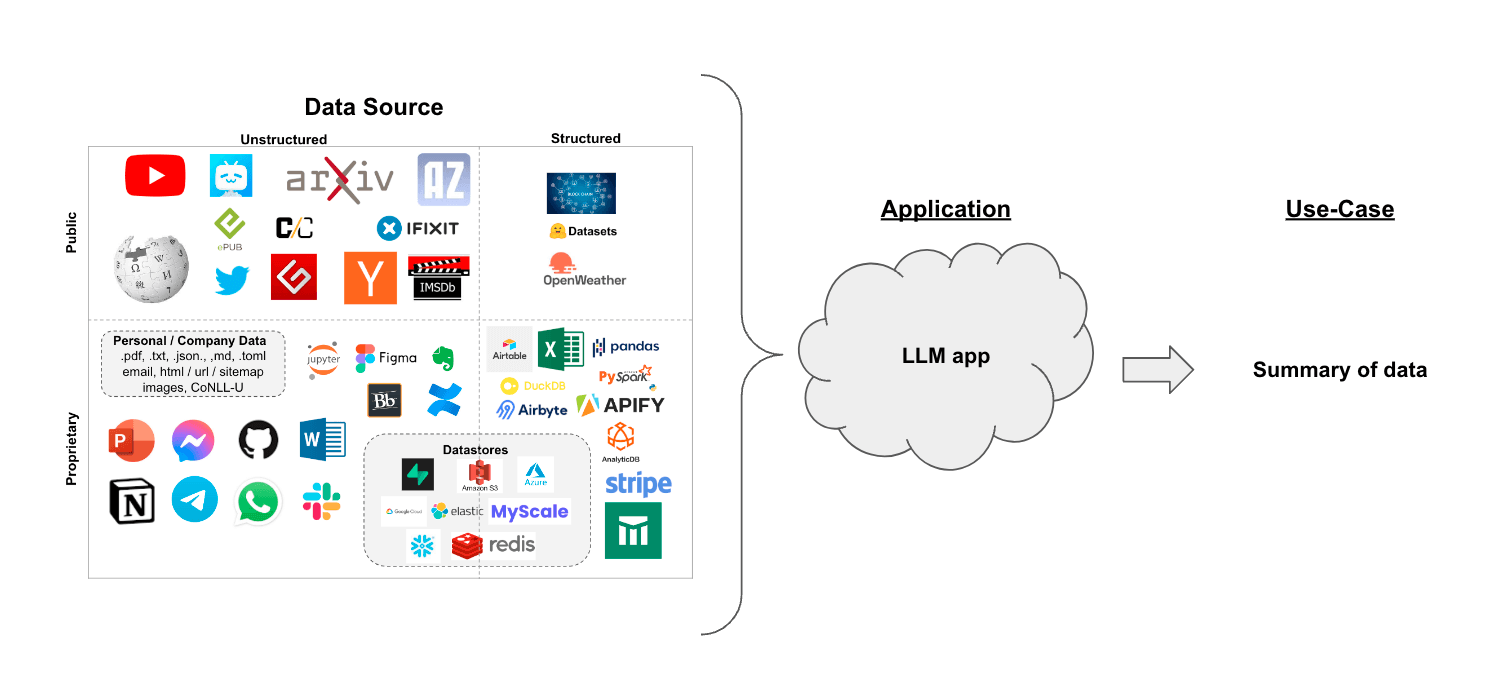


# Table of Contents


  
   
   

*   Introduction
*   Getting Started
*   Summarisation Methods
    - Option 1: Stuff
    - Option 2: Map-Reduce
    - Option 3: Refine
* Hands-On Example
* Going Deeper


# Introduction
LangChain v0.2 allows you to summarize documents efficiently using LLMs. Summarisation helps condense information, making it easier to digest large amounts of text. In this blog, we'll explore three main methods for summarisation:

- Stuff: Simple and straightforward.
- Map-Reduce: More complex but handles larger texts.
- Refine: Iterative and detailed.


# Getting Started
To begin, you need to install the necessary packages and set up your environment variables.

### 1. Install Packages

In [4]:
%pip install --upgrade --quiet langchain-openai tiktoken chromadb langchain langchainhub langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.6 MB/s eta 0:00:00


### 2. Set Environment Variables:



In [2]:
import os
os.environ['OPENAI_API_KEY'] = 'Your API Key'

We can use chain_type="stuff", especially if using larger context window models such as:

- 16k token OpenAI gpt-3.5-turbo-1106
- 100k token Anthropic [Claude-2](https://python.langchain.com/v0.1/docs/use_cases/summarization/#:~:text=We%20can%20use,chain_type%3D%22refine%22.)


We can also supply chain_type="map_reduce" or chain_type="refine".

In [9]:
from langchain.chains.summarize import load_summarize_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import ChatOpenAI

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-1106")
chain = load_summarize_chain(llm, chain_type="stuff")

response = chain.run(docs)
response

'The article discusses the concept of LLM-powered autonomous agents, which use large language models as their core controllers. It covers the components of these agents, including planning, memory, and tool use, as well as case studies and proof-of-concept examples. The challenges and limitations of using natural language interfaces for these agents are also discussed. The article provides citations and references for further reading.'

### API Reference:
- [load_summarize_chain](https://api.python.langchain.com/en/latest/chains/langchain.chains.summarize.chain.load_summarize_chain.html)
- [WebBaseLoader](https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html)
- [ChatOpenAI](https://api.python.langchain.com/en/latest/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html)

# Summarization Methods
## Option 1: Stuff
This method "stuffs" all documents into a single prompt and passes it to the LLM.

In [12]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import PromptTemplate

# Define prompt
prompt_template = """Write a concise summary of the following:
"{text}"
CONCISE SUMMARY:"""
prompt = PromptTemplate.from_template(prompt_template)

# Define LLM chain
llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-16k")
llm_chain = LLMChain(llm=llm, prompt=prompt)

# Define StuffDocumentsChain
stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="text")

docs = loader.load()
stuff_response = stuff_chain.run(docs)
stuff_response


'The article discusses the concept of building autonomous agents powered by large language models (LLMs). It explores the components of such agents, including planning, memory, and tool use. The article provides case studies and proof-of-concept examples of LLM-powered agents in various domains. It also highlights the challenges and limitations of using LLMs in autonomous agents.'

API Reference:
- [StuffDocumentsChain](https://api.python.langchain.com/en/latest/chains/langchain.chains.combine_documents.stuff.StuffDocumentsChain.html)
- [LLMChain](https://api.python.langchain.com/en/latest/chains/langchain.chains.llm.LLMChain.html)
- [PromptTemplate](https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.prompt.PromptTemplate.html)

### Option 2: Map-Reduce
Let's unpack the map reduce approach. For this, we'll first map each document to an individual summary using an LLMChain. Then we'll use a ReduceDocumentsChain to combine those summaries into a single global summary.

First, we specify the LLMChain to use for mapping each document to an individual summary:


In [14]:
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain_text_splitters import CharacterTextSplitter

llm = ChatOpenAI(temperature=0)

# Map
map_template = """The following is a set of documents
{docs}
Based on this list of docs, please identify the main themes
Helpful Answer:"""
map_prompt = PromptTemplate.from_template(map_template)
map_chain = LLMChain(llm=llm, prompt=map_prompt)

We can also use the Prompt Hub to store and fetch prompts.

In [15]:
from langchain import hub

map_prompt = hub.pull("rlm/map-prompt")
map_chain = LLMChain(llm=llm, prompt=map_prompt)


The ReduceDocumentsChain processes the document mapping results and condenses them into a single output. It uses a general CombineDocumentsChain (such as StuffDocumentsChain) but includes a feature to compress documents before sending them to the CombineDocumentsChain if their total size goes beyond token_max. In this instance, we can repurpose our chain for merging our documents to also compress them.

If the total number of tokens in our mapped documents exceeds 4000 tokens, we will recursively pass the documents in batches of less than 4000 tokens to our StuffDocumentsChain to generate batched summaries. Once these batched summaries collectively have fewer than 4000 tokens, we'll pass them all once more to the StuffDocumentsChain to produce the final summary.

In [16]:
# Reduce
reduce_template = """The following is set of summaries:
{docs}
Take these and distill it into a final, consolidated summary of the main themes.
Helpful Answer:"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

In [17]:
# Note we can also get this from the prompt hub, as noted above
reduce_prompt = hub.pull("rlm/map-prompt")

In [18]:
reduce_prompt

ChatPromptTemplate(input_variables=['docs'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'map-prompt', 'lc_hub_commit_hash': 'de4fba345f211a462584fc25b7077e69c1ba6cdcf4e21b7ec9abe457ddb16c87'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['docs'], template='The following is a set of documents:\n{docs}\nBased on this list of docs, please identify the main themes \nHelpful Answer:'))])

In [19]:
# Run chain
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# Combines and iteratively reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    combine_documents_chain=combine_documents_chain,
    collapse_documents_chain=combine_documents_chain,
    token_max=4000,
)

Combining our map and reduce chains into one:

In [20]:
# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    llm_chain=map_chain,
    reduce_documents_chain=reduce_documents_chain,
    document_variable_name="docs",
    return_intermediate_steps=False,
)

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)

In [21]:
map_reduce_chain.run(split_docs)

'The main themes identified in the set of documents are related to building autonomous agents powered by large language models (LLMs), components of the agent system including planning, memory, and tool use, examples of LLM-powered agents such as AutoGPT and GPT-Engineer, challenges in building and utilizing LLM-powered agents, and the importance of memory, self-reflection, and planning in autonomous agents. Additionally, there are discussions on improving model outputs through feedback and history, algorithm distillation for reinforcement learning, training models to learn from past outputs, and the importance of context and history in learning optimal reinforcement learning algorithms. Other themes include memory types, Maximum Inner Product Search (MIPS), similarity search algorithms such as Locality-Sensitive Hashing (LSH), Approximate Nearest Neighbors Oh Yeah (ANNOY), Hierarchical Navigable Small World (HNSW), Facebook AI Similarity Search (FAISS), and Scalable Nearest Neighbors 

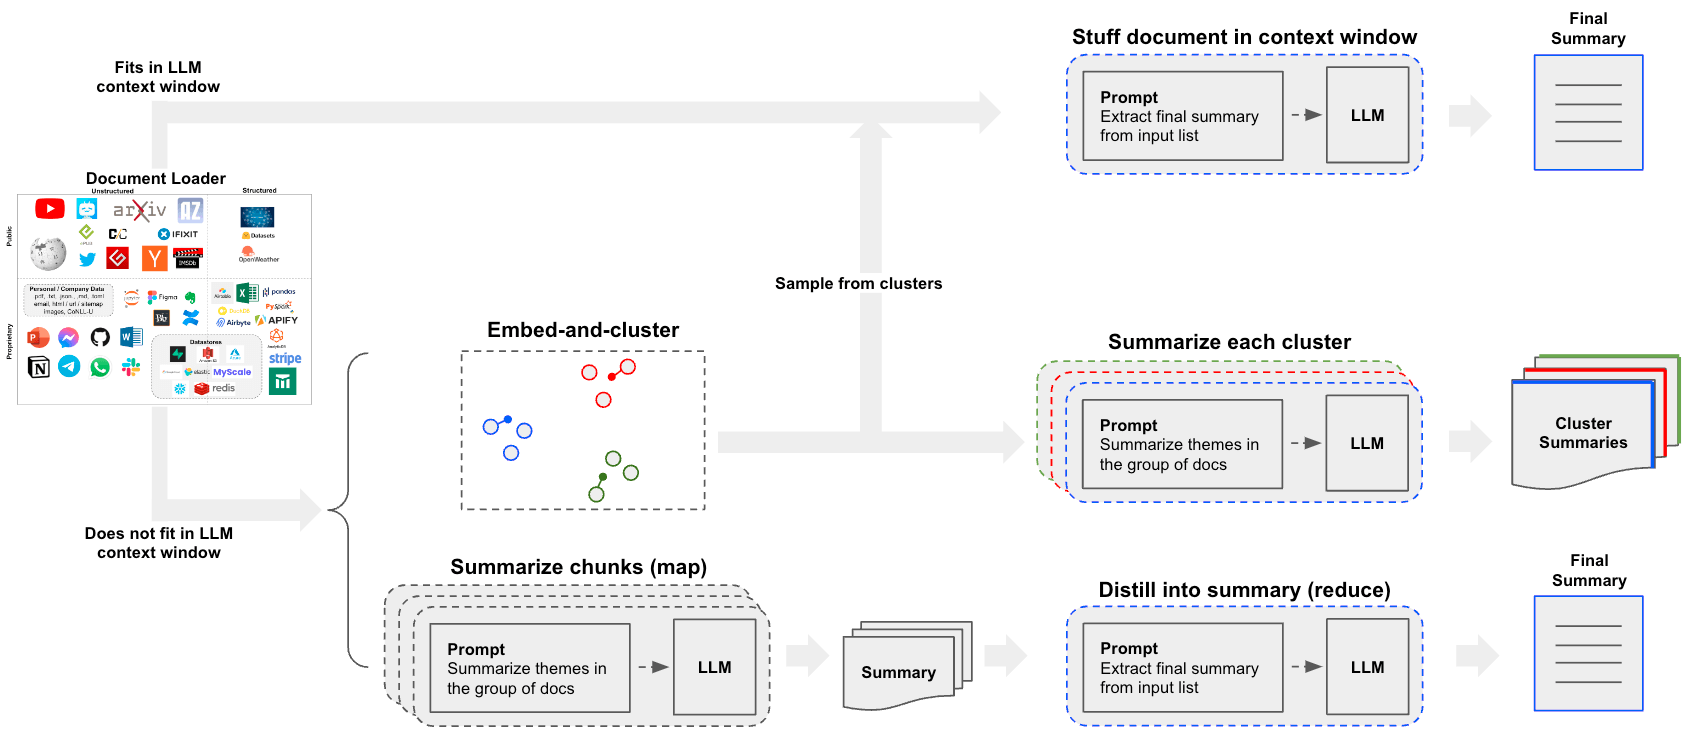

### Option 3. Refine
RefineDocumentsChain is similar to map-reduce:

The refine documents chain constructs a response by looping over the input documents and iteratively updating its answer. For each document, it passes all non-document inputs, the current document, and the latest intermediate answer to an LLM chain to get a new answer.

This can be easily run with the chain_type="refine" specified.

In [23]:
chain = load_summarize_chain(llm, chain_type="refine")
chain.run(split_docs)

'{\n    "thoughts": {\n        "text": "The additional context provided sheds light on the challenges faced in long-term planning, task decomposition, and the reliability of natural language interfaces in LLM-powered autonomous agents. The new references further emphasize the importance of reasoning and problem-solving capabilities in LLMs.",\n        "reasoning": "The new context highlights the limitations of LLMs in adjusting plans and the potential unreliability of model outputs, emphasizing the need for robust and error-tolerant systems. The references underscore the advancements in prompting, reasoning, and acting capabilities of LLMs.",\n        "plan": "Incorporate the challenges of long-term planning, task decomposition, and natural language interfaces along with the advancements in reasoning and problem-solving capabilities to provide a comprehensive view of the complexities involved in building autonomous agents powered by LLMs.",\n        "criticism": "N/A",\n        "speak"

It's also possible to supply a prompt and return intermediate steps.

In [24]:
prompt_template = """Write a concise summary of the following:
{text}
CONCISE SUMMARY:"""
prompt = PromptTemplate.from_template(prompt_template)

refine_template = (
    "Your job is to produce a final summary\n"
    "We have provided an existing summary up to a certain point: {existing_answer}\n"
    "We have the opportunity to refine the existing summary"
    "(only if needed) with some more context below.\n"
    "------------\n"
    "{text}\n"
    "------------\n"
    "Given the new context, refine the original summary in Italian"
    "If the context isn't useful, return the original summary."
)
refine_prompt = PromptTemplate.from_template(refine_template)
chain = load_summarize_chain(
    llm=llm,
    chain_type="refine",
    question_prompt=prompt,
    refine_prompt=refine_prompt,
    return_intermediate_steps=True,
    input_key="input_documents",
    output_key="output_text",
)
result = chain({"input_documents": split_docs}, return_only_outputs=True)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [25]:
result["output_text"]



'{\n    "thoughts": {\n        "text": "Dopo aver esaminato le idee chiave e le dimostrazioni sulla costruzione di agenti centrati su LLM, emergono alcune limitazioni comuni, come la sfida della pianificazione a lungo termine e della decomposizione dei compiti, nonché la questione della affidabilità dell\'interfaccia di linguaggio naturale.",\n        "reasoning": "Il riassunto originale già copre i punti chiave dell\'articolo che discute il concetto di costruzione di agenti autonomi alimentati da LLM, esplorando la pianificazione, la memoria e i componenti di utilizzo degli strumenti in tali agenti, nonché mostrando esempi di prova di concetto. La nuova aggiunta fornisce ulteriori dettagli sulle sfide affrontate dagli agenti LLM, come la difficoltà nel pianificare a lungo termine e l\'affidabilità dell\'interfaccia di linguaggio naturale.",\n        "plan": "Mantenere il riassunto originale poiché cattura efficacemente le idee principali presentate nell\'articolo, integrando le nuove 

In [26]:
print("\n\n".join(result["intermediate_steps"][:3]))

The article discusses the concept of building autonomous agents powered by LLM (large language model) as the core controller. It explores the components of planning, memory, and tool use in such agents, highlighting their potential for problem-solving and showcasing proof-of-concept examples. The use of LLM extends beyond generating content to being a powerful general problem solver.

L'articolo discute il concetto di costruire agenti autonomi alimentati da LLM (large language model) come controller principale. Esplora i componenti di pianificazione, memoria e utilizzo di strumenti in tali agenti, evidenziando il loro potenziale per la risoluzione dei problemi e mostrando esempi di proof-of-concept. L'uso di LLM si estende oltre la generazione di contenuti per diventare un potente risolutore generale di problemi. Inoltre, vengono presentati approcci come Task Decomposition, Self-Reflection e Reflexion per migliorare le capacità di ragionamento e di apprendimento degli agenti autonomi.
